<a href="https://colab.research.google.com/github/surya81/Encoder-Decoder-Model/blob/main/AutoEncoder_using_CNN_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.5], [0.5]),
  transforms.Lambda(lambda x: x.to(device))
  ])
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)
batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 948 kB 43.2 MB/s 
     |████████████████████████████████| 235 kB 67.3 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [4]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder= nn.Sequential(
        nn.Conv2d(1,32,3,stride = 3,padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2,stride = 2),
        nn.Conv2d(32,64,3,stride = 2,padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2,stride =1)

    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,3,stride = 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(32,16,5,stride = 3,padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(16,1 ,2,stride = 2,padding = 1),
        nn.Tanh()
        )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x 

In [5]:
model = AutoEncoder().to(device)
! pip install torch_summary
from torchsummary import summary 
summary(model,torch.zeros(2,1,28,28));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-

In [6]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

In [7]:
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [9]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [10]:
num_epochs = 20
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.181	val_loss: 0.096	(23.32s - 443.08s remaining)
EPOCH: 2.000	trn_loss: 0.085	val_loss: 0.075	(40.58s - 365.25s remaining)
EPOCH: 3.000	trn_loss: 0.072	val_loss: 0.066	(57.78s - 327.43s remaining)
EPOCH: 4.000	trn_loss: 0.065	val_loss: 0.061	(74.95s - 299.81s remaining)
EPOCH: 5.000	trn_loss: 0.060	val_loss: 0.057	(92.09s - 276.26s remaining)
EPOCH: 6.000	trn_loss: 0.057	val_loss: 0.054	(109.86s - 256.34s remaining)
EPOCH: 7.000	trn_loss: 0.055	val_loss: 0.053	(127.42s - 236.64s remaining)
EPOCH: 8.000	trn_loss: 0.053	val_loss: 0.051	(144.52s - 216.78s remaining)
EPOCH: 9.000	trn_loss: 0.052	val_loss: 0.050	(161.66s - 197.58s remaining)
EPOCH: 10.000	trn_loss: 0.050	val_loss: 0.049	(178.77s - 178.77s remaining)
EPOCH: 11.000	trn_loss: 0.049	val_loss: 0.048	(196.05s - 160.40s remaining)
EPOCH: 12.000	trn_loss: 0.048	val_loss: 0.047	(213.42s - 142.28s remaining)
EPOCH: 13.000	trn_loss: 0.047	val_loss: 0.046	(230.48s - 124.11s remaining)
EPOCH: 14.000	trn_loss: 0.

100%|██████████| 121/121 [00:00<00:00, 361.25it/s]


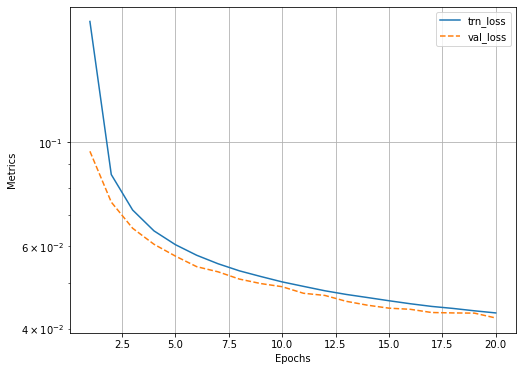

In [11]:
log.plot_epochs(log=True)

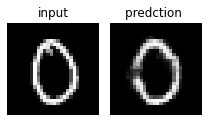

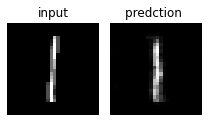

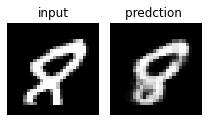

In [14]:
for _ in range(3):
  ix = np.random.randint(len(val_ds))
  im,_ = val_ds[ix]
  _im = model(im[None])[0]

  fig, ax = plt.subplots(1, 2, figsize=(3,3))
  show(im[0],ax= ax[0],title = 'input')
  show(_im[0],ax = ax[1],title = 'predction ')
  plt.tight_layout()
  plt.show()